In [ ]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tabulate import tabulate
import pandas as pd
import shutil
np.set_printoptions(threshold=np.inf)


In [ ]:
# Import module yang digunakan
from preprocessing.scarpping_component import extract_component_by_images
from feature_extraction.poc import POC
from feature_extraction.vektor import Vektor
from feature_extraction.quadran import Quadran
import re

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

# load model dan shape predictor untuk deteksi wajah
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

components_setup = {
    'mulut': {
        'object_name': 'mouth',
        'object_rectangle': {"x_right": 54, "x_left": 48, "y_highest": 52, "y_lowest": 57},
        'pixel_shifting': {"pixel_x": 25, "pixel_y": 5},
        'object_dimension': {'width': 139, 'height': 39}
    },
    'mata_kiri': {
        'object_name': 'eye_left',
        'object_rectangle': {"x_right": 39, "x_left": 36, "y_highest": 38, "y_lowest": 40},
        'pixel_shifting': {"pixel_x": 20, "pixel_y": 15},
        'object_dimension': {'width': 81, 'height': 43}
    },
    'mata_kanan': {
        'object_name': 'eye_right',
        'object_rectangle': {"x_right": 45, "x_left": 42, "y_highest": 43, "y_lowest": 47},
        'pixel_shifting': {"pixel_x": 20, "pixel_y": 15},
        'object_dimension': {'width': 81, 'height': 43}
    },
    'alis_kiri': {
        'object_name': 'eyebrow_left',
        'object_rectangle': {"x_right": 21, "x_left": 17, "y_highest": 18, "y_lowest": 21},
        'pixel_shifting': {"pixel_x": 15, "pixel_y": 5},
        'object_dimension': {'width': 111, 'height': 28}
    },
    'alis_kanan': {
        'object_name': 'eyebrow_right',
        'object_rectangle': {"x_right": 26, "x_left": 22, "y_highest": 25, "y_lowest": 22},
        'pixel_shifting': {"pixel_x": 15, "pixel_y": 5},
        'object_dimension': {'width': 111, 'height': 28}
    }
}

# Inisialisasi variabel untuk path url dan blok size
blockSize = 7
pathDirectory = {
    "base_path_dataset": "dataset",
    "base_dataset_input" : "dataset/casme_custom_from_one",
    "result_dataset" : "output", 
    "component_image" : "component_to_images", 
    "video_frame" :"video_to_images"
}

# Inisialisasi variabel untuk menyimpan data dari masing-masing komponen
frames_data_quadran = []
frames_data_all_component = []
frames_data_quadran_column = ['sumX', 'sumY', 'Tetha', 'Magnitude', 'JumlahQuadran']
quadran_dimensions = ['Q1', 'Q2', 'Q3', 'Q4']
frames_data = {component_name: [] for component_name in components_setup}
total_blocks_components = {component_name: 0 for component_name in components_setup}
data_blocks_first_image = {component_name: None for component_name in components_setup}
index = {component_name: 0 for component_name in components_setup}

# Hitung total blok dari masing-masing komponen lalu disetup kedalam total_blocks_components
for component_name, component_info in components_setup.items():
    total_blocks_components[component_name] = int((component_info['object_dimension']['width'] / blockSize) * (component_info['object_dimension']['height'] / blockSize))

# Loop melalui setiap kunci dan nilai di pathDirectory dan hapus direktorinya
for key, value in pathDirectory.items():
    # Jika tidak mengandung base, hapus direktori sesuai dengan nilai yang ada
    if not "base" in key:
        shutil.rmtree(value, ignore_errors=True)

# Looping folder label didalam base_dataset_input
for foldername_label in os.listdir(pathDirectory['base_dataset_input']):
    foldername_label_join_basepath = os.path.join(pathDirectory['base_dataset_input'], foldername_label)
    # Jika folder nya tidak ada skip looping ini
    if not os.path.isdir(foldername_label_join_basepath):
        continue
    
    # Looping folder label didalam foldername_label_join_basepath 
    for foldername in os.listdir(foldername_label_join_basepath):
        foldername_join_basepath = os.path.join(foldername_label_join_basepath, foldername)
        # Jika folder nya tidak ada skip looping ini
        if not os.path.isdir(foldername_join_basepath):
            continue

        # Reset variabel setiap kali mulai looping folder baru
        data_blocks_first_image = {component_name: None for component_name in components_setup}
        index = {component_name: 0 for component_name in components_setup}

        # looping semua file yang ada didalam
        for filename in sorted(os.listdir(foldername_join_basepath), key=natural_sort_key):
            if filename.endswith(".jpg") or filename.endswith(".png"): 

                # Read path sesuai dengan foldername_join_basepath dijoin path dengan filename
                image = cv2.imread(os.path.join(foldername_join_basepath, filename))
                # Resize image ke ukuran yang diinginkan
                # image = cv2.resize(image, (600, 500))
                # Cpmvert image ke grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Deteksi shape muka didalam grayscale image
                rects = detector(gray)

                if not index[component_name] == 0:
                    # Buat variabel frames_data_all_component untuk menampung data current frame
                    frame_data_all_component = {'Frame': f"{index[component_name] + 1}({filename.split('.')[0]})"}
                    # Buat variabel frame_data_quadran untuk menampung data current frame
                    frame_data_quadran = {'Frame': f"{index[component_name] + 1}({filename.split('.')[0]})"}

                # Memproses rects untuk setiap bentuk wajah yang terdeteksi
                for rect in rects:
                    # Ambil bentuk wajah dalam bentuk shape sesuai dengan model predictor
                    shape = predictor(gray, rect)
                    # Memproses setiap komponen wajah
                    for component_name, component_info in components_setup.items():
                        print(f"\n{foldername}-{filename.split('.')[0]}-{component_info['object_name']}:")
                        # Inisialisasi variabel sum_data_by_quadran untuk menyimpan data hasil quadran
                        sum_data_by_quadran = {}
                        # Buat variabel frame_data untuk menampung data current frame
                        frame_data = {'Frame': f"{index[component_name] + 1}({filename.split('.')[0]})"}

                        # Looping untuk setiap atribut dalam frames_data_quadran_column
                        for column in frames_data_quadran_column:
                            # Inisialisasi sub-dictionary untuk setiap atribut dalam frames_data_quadran_column yang defaultnya 0
                            sum_data_by_quadran[column] = {quadrant: 0 for quadrant in quadran_dimensions}

                        # Ambil data blok image dari return fungsi extract_component_by_images
                        data_blocks_image_current = extract_component_by_images(
                            image=image,
                            shape=shape,
                            frameName=filename.split(".")[0],
                            objectName=component_info['object_name'],
                            objectRectangle=component_info['object_rectangle'],
                            pixelShifting=component_info['pixel_shifting'],
                            objectDimension=component_info['object_dimension']
                        )
                        
                        # Ambil frame pertama dari perulangan lalu simpan di variabel dan skip (lanjutkan ke frame berikut)
                        if data_blocks_first_image[component_name] is None:
                            # --- Setup bagian 4qmv Dataset ---
                            # Inisialisasi data untuk setiap blok dan setiap kuadran dengan nilai sesuai sum_data_by_quadran
                            # for quadrant in quadran_dimensions:
                            #     for feature in frames_data_quadran_column:
                            #         # Buat nama kolom dengan menggunakan template yang diberikan
                            #         column_name = f"{component_name}_{feature}_{quadrant}"
                            #         # Set value sum_data_by_quadran[feature][quadrant] ke frame_data_quadran sesuai column_name nya
                            #         frame_data_quadran[column_name] = sum_data_by_quadran[feature][quadrant]

                            # --- Setup bagian Nilai Fitur Dataset ---
                            # Inisialisasi data untuk setiap blok
                            # for i in range(total_blocks_components[component_name]):
                                # Tambahkan data ke frame_data sesuai dengan indexnya
                                # frame_data[f'X{i+1}'] = 0
                                # frame_data[f'Y{i+1}'] = 0
                                # frame_data[f'Tetha{i+1}'] = 0
                                # frame_data[f'Magnitude{i+1}'] = 0
                                # # Tambahkan data ke frame_data_all_component sesuai dengan indexnya
                                # frame_data_all_component[f'{component_name}-X{i+1}'] = 0
                                # frame_data_all_component[f'{component_name}-Y{i+1}'] = 0
                                # frame_data_all_component[f'{component_name}-Tetha{i+1}'] = 0
                                # frame_data_all_component[f'{component_name}-Magnitude{i+1}'] = 0

                            # Append data frame ke list frames_data sesuai dengan component_name
                            frames_data[component_name].append(frame_data)
                            # Tambahkan kolom "Folder Path" dengan nilai folder saat ini
                            frame_data['Folder Path'] = foldername
                            # Tambahkan kolom "Label" dengan nilai label saat ini
                            frame_data['Label'] = foldername_label
                            # Set value data_blocks_first_image[component_name] ke data_blocks_image_current
                            data_blocks_first_image[component_name] = data_blocks_image_current
                            # Skip looping nya ke looping selanjutnya
                            continue

                        # # Tampilkan data block image current ke matplotlib
                        # plt.imshow(np.uint8(data_blocks_image_current), cmap="gray")

                        # Inisiasi class POC
                        initPOC = POC(data_blocks_first_image[component_name], data_blocks_image_current, blockSize) 
                        # Pemanggilan fungsi pocCalc() untuk menghitung nilai POC disetiap gambar
                        valPOC = initPOC.getPOC() 

                        # Pemanggilan class dan method untuk menampilkan quiver / gambar panah
                        initQuiv = Vektor(valPOC, blockSize)
                        quivData = initQuiv.getVektor() 

                        # plt.quiver(quivData[:, 0], quivData[:, 1], quivData[:, 2], quivData[:, 3], scale=1, scale_units='xy', angles='xy', color="r")    

                        # # num = 0
                        # for rect_def in valPOC[2]:
                        #     x, y, width, height = rect_def
                            
                        #     rects = patches.Rectangle((x,y), width,height, edgecolor='r', facecolor='none') 
                        #     plt.gca().add_patch(rects)
                            
                        #     # plt.text(x,y,f'({num})', color="blue") 
                        #     # num += 1

                        # Pemanggilan class untuk mengeluarkan nilai karakteristik vektor
                        # blok ke, x,y,tetha, magnitude, dan quadran ke
                        initQuadran = Quadran(quivData) 
                        quadran = initQuadran.getQuadran()

                        # print(tabulate(quadran, headers=['Blok Ke', 'X', 'Y', 'Tetha', 'Magnitude', 'Quadran Ke']))
                        # plt.axis('on') 
                        # plt.show() 

                        # Update frame_data dengan data quadran
                        for i, quad in enumerate(quadran):
                            # --- Setup bagian Nilai Fitur Dataset ---
                            # Set data kedalam frame_data sesuai column nya
                            frame_data[f'X{i+1}'] = quad[1]
                            frame_data[f'Y{i+1}'] = quad[2]
                            frame_data[f'Tetha{i+1}'] = quad[3]
                            frame_data[f'Magnitude{i+1}'] = quad[4]

                            # Set data kedalam frame_data_all_component sesuai columnnya
                            frame_data_all_component[f'{component_name}-X{i+1}'] = quad[1]
                            frame_data_all_component[f'{component_name}-Y{i+1}'] = quad[2]
                            frame_data_all_component[f'{component_name}-Tetha{i+1}'] = quad[3]
                            frame_data_all_component[f'{component_name}-Magnitude{i+1}'] = quad[4]

                            # --- Setup bagian 4qmv Dataset ---
                            # Cek apakah quad[5] ada didalam array quadran_dimensions
                            if quad[5] in quadran_dimensions:
                                # Tambahkan nilai quad[1] ke sumX pada kuadran yang sesuai
                                sum_data_by_quadran['sumX'][quad[5]] += quad[1]
                                # Tambahkan nilai quad[2] ke sumY pada kuadran yang sesuai
                                sum_data_by_quadran['sumY'][quad[5]] += quad[2]
                                # Tambahkan nilai quad[3] ke Tetha pada kuadran yang sesuai
                                sum_data_by_quadran['Tetha'][quad[5]] += quad[3]
                                # Tambahkan nilai quad[4] ke Magnitude pada kuadran yang sesuai
                                sum_data_by_quadran['Magnitude'][quad[5]] += quad[4]
                                # Tambahkan jumlah quadran sesuai dengan quad[5] ke JumlahQuadran pada kuadran yang sesuai
                                sum_data_by_quadran['JumlahQuadran'][quad[5]] += 1
                        
                        # --- Setup bagian Nilai Fitur Dataset ---
                        # Append data frame ke list
                        frames_data[component_name].append(frame_data)
                        # Tambahkan kolom "Folder Path" dengan nilai folder saat ini
                        frame_data['Folder Path'] = foldername
                        # Tambahkan kolom "Label" dengan nilai label saat ini
                        frame_data['Label'] = foldername_label

                        # --- Setup bagian 4qmv Dataset ---
                        # Inisialisasi data untuk setiap blok dan setiap kuadran dengan nilai sesuai sum_data_by_quadran
                        for quadran in quadran_dimensions:
                            for feature in frames_data_quadran_column:
                                # Buat nama kolom dengan menggunakan template yang diberikan
                                column_name = f"{component_name}_{feature}_{quadran}"
                                # Set value sum_data_by_quadran[feature][quadran] ke frame_data_quadran sesuai column_name nya
                                frame_data_quadran[column_name] = sum_data_by_quadran[feature][quadran]

                # --- Setup bagian 4qmv Dataset ---
                if not index[component_name] == 0:
                    # Append data frame ke list frames_data_quadran untuk 4qmv
                    frames_data_quadran.append(frame_data_quadran)
                    # print("Frame Quadran", frame_data_quadran)
                    # Tambahkan kolom "Folder Path" dengan nilai folder saat ini
                    frame_data_quadran['Folder Path'] = foldername
                    # Tambahkan kolom "Label" dengan nilai label saat ini
                    frame_data_quadran['Label'] = foldername_label

                if not index[component_name] == 0:
                    # --- Setup bagian frames data all component Dataset ---
                    # Append data frame ke list frames_data_quadran untuk 4qmv
                    frames_data_all_component.append(frame_data_all_component)
                    # print("Frame Quadran", frame_data_quadran)
                    # Tambahkan kolom "Folder Path" dengan nilai folder saat ini
                    frame_data_all_component['Folder Path'] = foldername
                    # Tambahkan kolom "Label" dengan nilai label saat ini
                    frame_data_all_component['Label'] = foldername_label

                # Update index per component_name
                index[component_name] += 1

# Membuat direktori jika belum ada untuk outputnya
output_csv_dir = os.path.join(pathDirectory['result_dataset'], 'csv')
output_excel_dir = os.path.join(pathDirectory['result_dataset'], 'excel')
os.makedirs(output_csv_dir, exist_ok=True)
os.makedirs(output_excel_dir, exist_ok=True)

# Hapus file output dari semua tipe dataset baik csv dan xlsx jika ada (Nilai fitur)
for component_name in components_setup:
    csv_file_path = os.path.join(pathDirectory['result_dataset'], 'csv', f'{component_name}.csv')
    xlsx_file_path = os.path.join(pathDirectory['result_dataset'], 'excel', f'{component_name}.xlsx')
    if os.path.exists(csv_file_path):
        os.remove(csv_file_path)
    if os.path.exists(xlsx_file_path):
        os.remove(xlsx_file_path)

# Export dataframe ke dalam file csv dan xlsx sesuai dengan masing-masing component untuk fitur ekstrasi biasa
for component_name, data_frame in frames_data.items():
    # Initialisasi dataframe dengan pandas
    df = pd.DataFrame(data_frame)
    
    # Simpan ke file CSV
    nama_file_csv = f'{output_csv_dir}/{component_name}.csv'
    df.to_csv(nama_file_csv, index=False, float_format=None)
    
    # Simpan ke file Excel
    nama_file_xlsx = f'{output_excel_dir}/{component_name}.xlsx'
    df.to_excel(nama_file_xlsx, index=False, float_format=None)

# Export dataframe ke dalam file csv dan xlsx sesuai frames_data_quadran untuk fitur ekstraksi 4qmv
# Initialisasi dataframe dengan pandas
df_4qmv = pd.DataFrame(frames_data_quadran)

# Inisialisasi nama file untuk dataset 4qmv
nama_file_csv = f'{output_csv_dir}/4qmv-all-component.csv'
nama_file_xlsx = f'{output_excel_dir}/4qmv-all-component.xlsx'

# Hapus file output dari semua tipe dataset baik csv dan xlsx jika ada (4qmv)
if os.path.exists(nama_file_csv):
    os.remove(nama_file_csv)
if os.path.exists(nama_file_xlsx):
    os.remove(nama_file_xlsx)

# Simpan ke file CSV
df_4qmv.to_csv(nama_file_csv, index=False, float_format=None)

# Simpan ke file Excel
df_4qmv.to_excel(nama_file_xlsx, index=False, float_format=None)

# Export dataframe ke dalam file csv dan xlsx sesuai frames_data_all_component untuk fitur ekstraksi nilai fiturnya
# Initialisasi dataframe dengan pandas
df_fitur_all = pd.DataFrame(frames_data_all_component)

# Inisialisasi nama file untuk dataset 4qmv
nama_file_csv = f'{output_csv_dir}/nilai-fitur-all-component.csv'
nama_file_xlsx = f'{output_excel_dir}/nilai-fitur-all-component.xlsx'

# Hapus file output dari semua tipe dataset baik csv dan xlsx jika ada (4qmv)
if os.path.exists(nama_file_csv):
    os.remove(nama_file_csv)
if os.path.exists(nama_file_xlsx):
    os.remove(nama_file_xlsx)

# Simpan ke file CSV
df_fitur_all.to_csv(nama_file_csv, index=False, float_format=None)

# Simpan ke file Excel
df_fitur_all.to_excel(nama_file_xlsx, index=False, float_format=None)

output/csv/nilai-fitur-all-component.csv

Best combination found:
{'C': 0.01, 'kernel': 'linear', 'gamma': 'scale'}
Best accuracy: 0.9968253968253968
Accuracy: 0.9968253968253968

Confusion Matrix:
[[439   0   1   0]
 [  0 311   0   0]
 [  2   0 511   1]
 [  1   0   0 309]]


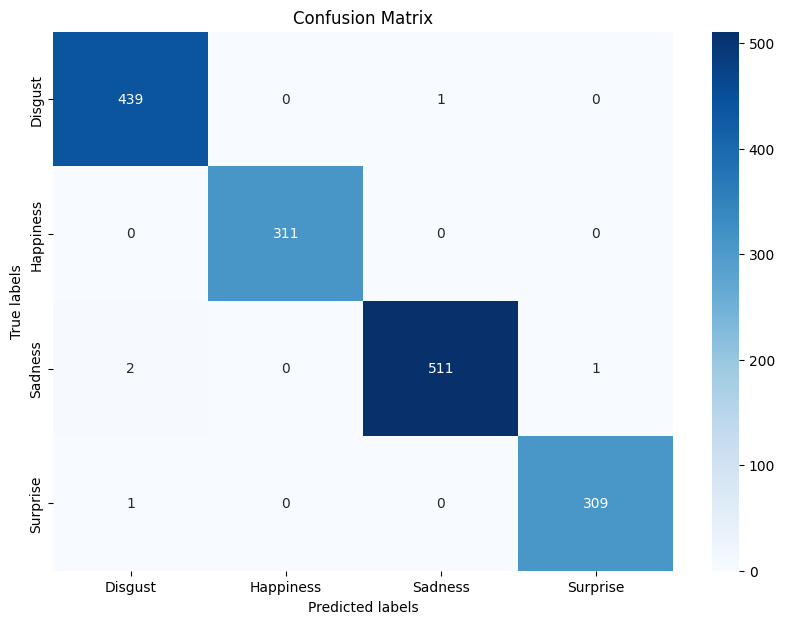

In [1]:
# Random Sampling Fitur All Component
from clasification.svm import SVMClassifier

# Load the dataset and initialize the classifier
# dataset_file = 'test-output/4qmv-all-component.csv'
# dataset_file = 'test-output/nilai-fitur-all-component.csv'
# dataset_file = 'output/csv/4qmv-all-component.csv'
dataset_file = 'output/csv/nilai-fitur-all-component.csv'
label_column = 'Label'
except_feature_columns = ['Frame', 'Folder Path', 'Label']  # Columns to exclude

# Initialize the classifier
classifier = SVMClassifier(dataset_file, label_column, except_feature_column=except_feature_columns)

# Load, split, train, evaluate and save the model
classifier.load_data()
classifier.split_data(test_size=0.2)
classifier.train_model(autoParams=True)
classifier.evaluate_model()
classifier.save_model('svm_model_random_sampling.joblib', 'label_encoder_random_sampling.joblib')

output/csv/nilai-fitur-all-component.csv
Best parameters found: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9923783693135275
Cross-validated Accuracy: 0.9923780487804879

Confusion Matrix:
[[2045    5    9    5]
 [   2 1509    1    5]
 [  12    3 2759    7]
 [   2    8    1 1499]]


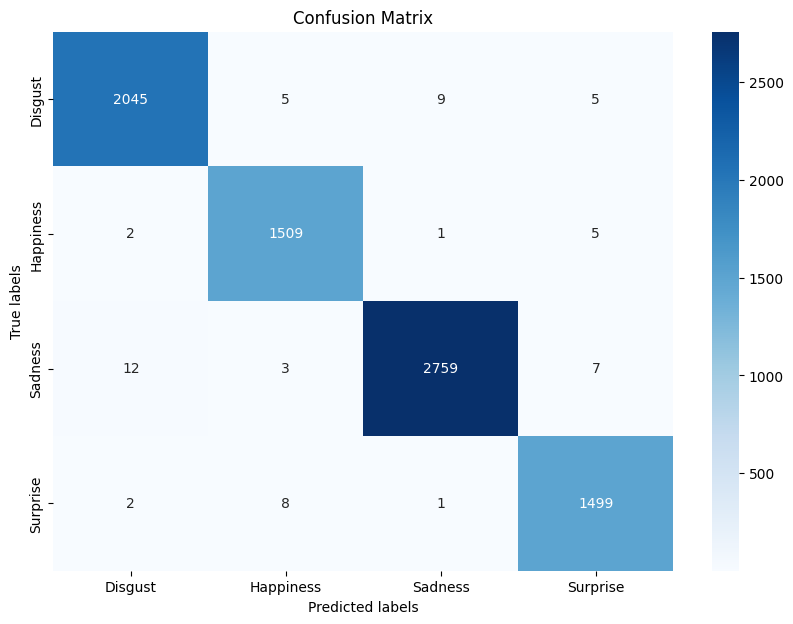

In [2]:
# KFOLD Fitur All Component
from clasification.svm import SVMClassifier

# Path dataset
dataset_file = 'output/csv/nilai-fitur-all-component.csv'
label_column = 'Label'
except_feature_columns = ['Frame', 'Folder Path', 'Label']  # Kolom yang dikecualikan

# Inisialisasi classifier
classifier_kfold = SVMClassifier(dataset_file, label_column, except_feature_column=except_feature_columns)

# Load data
classifier_kfold.load_data()

# Train model menggunakan k-fold cross validation
classifier_kfold.train_model_cross_validation(cv=10)

# Evaluate model menggunakan k-fold cross validation
classifier_kfold.evaluate_model_cross_validation()

# Save model
classifier_kfold.save_model('svm_model_kfold.joblib', 'label_encoder_kfold.joblib')

output/csv/4qmv-all-component.csv

Best combination found:
{'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}
Best accuracy: 0.8704761904761905
Accuracy: 0.8704761904761905

Confusion Matrix:
[[384  19  18  19]
 [ 19 253  20  19]
 [ 19  16 461  18]
 [ 14  11  12 273]]


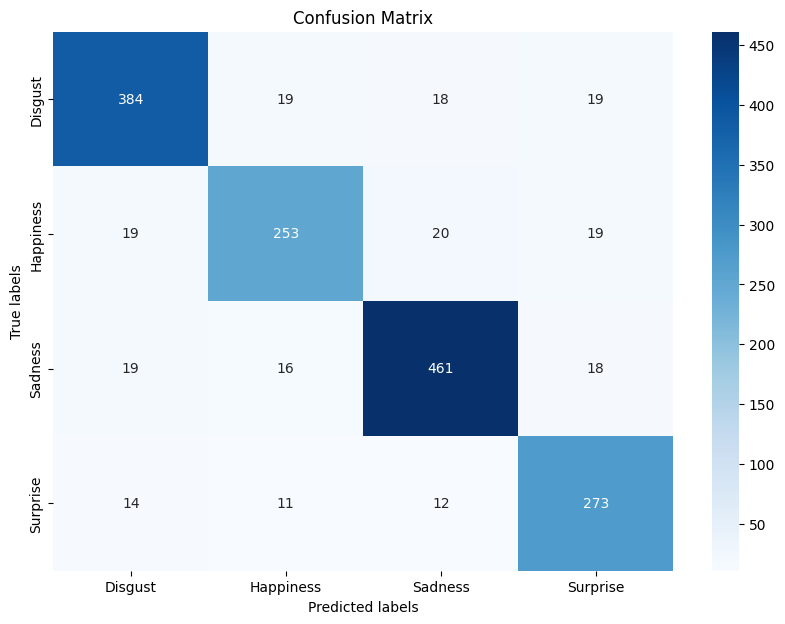

In [2]:
# Random Sampling 4QMV
from clasification.svm import SVMClassifier

# Load the dataset and initialize the classifier
# dataset_file = 'test-output/4qmv-all-component.csv'
# dataset_file = 'test-output/nilai-fitur-all-component.csv'
dataset_file = 'output/csv/4qmv-all-component.csv'
label_column = 'Label'
except_feature_columns = ['Frame', 'Folder Path', 'Label']  # Columns to exclude

# Initialize the classifier
classifier = SVMClassifier(dataset_file, label_column, except_feature_column=except_feature_columns)

# Load, split, train, evaluate and save the model
classifier.load_data()
classifier.split_data(test_size=0.2)
classifier.train_model(autoParams=True)
classifier.evaluate_model()
classifier.save_model('4qmv_svm_model_random_sampling.joblib', '4qmv_label_encoder_random_sampling.joblib')

test-output/onsetoffset_tanpa_fear/4qmv-all-component.csv

Best combination found:
{'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}
Best accuracy: 0.8765957446808511
Accuracy: 0.8765957446808511

Confusion Matrix:
[[42  3  2  2]
 [ 1 57  2  4]
 [ 2  5 52  4]
 [ 2  1  1 55]]


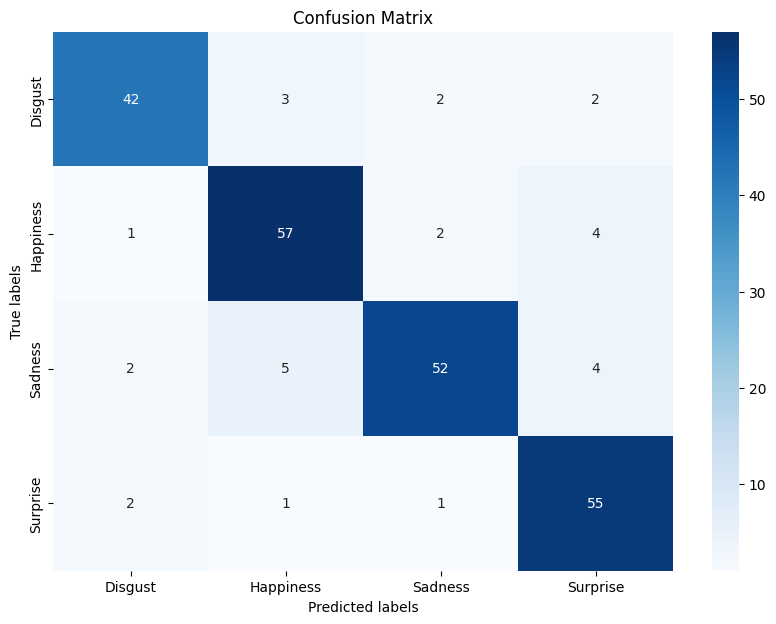

In [1]:
# Random Sampling 4QMV
from clasification.svm import SVMClassifier

# Load the dataset and initialize the classifier
# dataset_file = 'test-output/4qmv-all-component.csv'
# dataset_file = 'test-output/nilai-fitur-all-component.csv'
# dataset_file = 'output/csv/4qmv-all-component.csv'
dataset_file = 'test-output/onsetoffset_tanpa_fear/4qmv-all-component.csv'
label_column = 'Label'
except_feature_columns = ['Frame', 'Folder Path', 'Label']  # Columns to exclude

# Initialize the classifier
classifier = SVMClassifier(dataset_file, label_column, except_feature_column=except_feature_columns)

# Load, split, train, evaluate and save the model
classifier.load_data()
classifier.split_data(test_size=0.2)
classifier.train_model(autoParams=True)
classifier.evaluate_model()
classifier.save_model('4qmv_svm_model_kfold.joblib', '4qmv_label_encoder_kfold.joblib')

In [3]:
# KFOLD 4QMV
from clasification.svm import SVMClassifier

# Load the dataset and initialize the classifier 
# dataset_file = 'test-output/4qmv-all-component.csv'
# dataset_file = 'test-output/nilai-fitur-all-component.csv'
dataset_file = 'test-output/onsetoffset_tanpa_fear/4qmv-all-component.csv'
label_column = 'Label'
except_feature_columns = ['Frame', 'Folder Path', 'Label']  # Columns to exclude

# Inisialisasi classifier
classifier_kfold = SVMClassifier(dataset_file, label_column, except_feature_column=except_feature_columns)

# Load data
classifier_kfold.load_data()

# Train model menggunakan k-fold cross validation
classifier_kfold.train_model_cross_validation(cv=10)

# Evaluate model menggunakan k-fold cross validation
classifier_kfold.evaluate_model_cross_validation()

# Save model
classifier_kfold.save_model('4qmv_svm_model_kfold2.joblib', '4qmv_label_encoder_kfold2.joblib')

test-output/onsetoffset_tanpa_fear/4qmv-all-component.csv
